# Utilities
> Useful function and utilities

In [ ]:
# default_exp utils

## Import Modules

In [ ]:
# export
import logging
import requests
import shutil
import tarfile
import tempfile
from datetime import datetime
from mimetypes import types_map
from pathlib import Path
from typing import Callable, List, Union
from zipfile import ZipFile

import graphviz
import pandas as pd
from bs4 import BeautifulSoup
from IPython.core import magic
from IPython.display import Javascript
from ipywidgets import Output, VBox, Button, HTML
from PIL import Image
from tqdm.notebook import tqdm
from uuid import uuid4


PathStr = Union[Path, str]
PathURL = Union[Path, str]


In [ ]:
# export
def is_jupyter():
    try:
        ishell = get_ipython()
        shell = ishell.__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        elif "google.colab._shell.Shell" in str(ishell):
            return True # Colab compatibility
        else:
            return False  # Other type (?)
    except NameError:
        return False  # Probably standard Python interpreter
    
IS_JUPYTER = is_jupyter()

In [ ]:
# exporti
logger = logging.getLogger("unpackai.utils")

In [ ]:
# hide
# To be able to run the tests in the Notebook
from pathlib import Path
import ipytest
import sys

ipytest.autoconfig()

root_dir = Path("..").resolve()
sys.path.append(str(root_dir / "test"))


In [ ]:
# exportest
# For Test Cases (might have duplicate import because it will be in a dedicated file)
import requests
from datetime import datetime, timedelta
from pathlib import Path
from shutil import copy, rmtree
from typing import List

import graphviz
import numpy as np
import pandas as pd
import pytest
from PIL import Image
from test_common.utils_4_tests import DATA_DIR, IMG_DIR, check_no_log, check_only_warning

## Image

### Cleaning up error image

In some cases, we have error image that will interrupt model trainging. We can use ```clean_error_img``` to clean the image folder

In [ ]:
# export
def check_img(
    img: Path,
    formats: List[str] = [".jpg", ".jpeg", ".png", ".bmp"],
) -> None:
    """
    Check on a single image,
    If it's quality is troublesome
        we unlink/ditch the image
    """
    img = Path(img)
    # check if this path is an image
    if img.suffix.lower().split("?")[0] not in formats:
        return

    try:
        # try to open that image and then (to check truncated image)
        # We need to include in a with block to close the image before deleting
        with Image.open(img) as im:
            im.load()
    except Exception:
        if img.exists():
            img.unlink()
            logging.warning(f"Removed erroneous img: {img}")
            return


def clean_error_img(
    path: Path,
    progress: bool = True,
) -> None:
    """
    - path: an image directory
    - progress: do we print out progress bar or not
        default True
    """
    path = Path(path)

    # check directory existence
    if path.exists() == False:
        raise FileExistsError(
            f"""path does not exists on:{path}, 
    make sure there is a directory "{path.name}".
    under directory "{path.parent}"
    """)

    # create iterator, probably with progress bar
    iterator = tqdm(list(path.iterdir()), leave=False)\
        if progress else path.iterdir()

    for obj in iterator:
        if obj.is_dir():
            # use recursion to clean the sub folder
            clean_error_img(obj, progress=progress)
        else:
            # cheking on a single image
            check_img(obj)

In [ ]:
# exportest

images_rob = list((IMG_DIR / "robustness").glob("*.*"))
IMG_RGB = Image.new("RGB", (60, 30), color=(73, 109, 137))
IMG_RGBA = Image.new("RGBA", (60, 30), color=(73, 109, 137, 100))

@pytest.mark.parametrize("img", images_rob, ids=[i.name for i in images_rob])
def test_check_img_error(img: Path, tmpdir, caplog):
    """Test check_img with incorrect images"""
    img_copy = Path(tmpdir) / img.name
    copy(img, img_copy)
    check_img(img_copy)
    check_only_warning(caplog, img.name)
    assert not img_copy.is_file(), f"File {img_copy} not be deleted"


def test_check_img_empty_wrong_suffix(tmpdir, caplog):
    """Test check_img with wrong image that does not have a correct extension"""
    img_path = Path(tmpdir) / "empty.txt"
    img_path.write_bytes(b"")
    check_img(img_path)
    check_no_log(caplog)
    assert img_path.is_file(), f"Image {img_path} not found"


@pytest.mark.parametrize("img", [IMG_RGB, IMG_RGBA])
@pytest.mark.parametrize("ext", ["png", "bmp", "jpg", "jpeg"])
def test_check_img_correct(img: Image, ext: str, tmpdir, caplog):
    """Correct that correct image is not removed"""
    alpha_suffix = "_alpha" if len(img.getcolors()[0][1]) == 4 else ""
    if alpha_suffix and ext.startswith("jp"):
        pytest.skip("JPG does not support RGBA")

    img_path = Path(tmpdir) / f"correct_image_blue{alpha_suffix}.{ext}"
    img.save(img_path)
    check_img(img_path)
    check_no_log(caplog)
    assert img_path.is_file(), f"Image {img_path} not found"


In [ ]:
# exportest

def test_clean_error_img(tmpdir, monkeypatch) -> None:
    """Test clean_error_img"""
    for img in images_rob:
        copy(img, Path(tmpdir) / img.name)

    monkeypatch.chdir(tmpdir)
    root = Path(".")

    sub1 = root / "sub1"
    sub2 = root / "sub2"
    sub1.mkdir()
    sub2.mkdir()
    sub3 = sub2 / "sub3"
    sub3.mkdir()


    (sub1 / "file11.BMP").write_text("fake image")
    (sub1/"file12 haha.jpg").write_text("fake image")
    (sub1 / "file13 haha.txt").write_text("not image")
    IMG_RGB.save(sub1 / "img14_good.jpg")
    IMG_RGBA.save(sub1 / "img15_good.png")

    (sub2 / "file21.jpg").write_text("fake image")
    (sub2 / "file22.jpeg").write_text("fake image")

    (sub3 / "file31.jpeg").write_text("fake image")
    IMG_RGB.save(sub3 / "img32_good.jpeg")
    IMG_RGBA.save(sub3 / "img33_good.bmp")


    good: List[Path] = list()
    bad: List[Path] = list()

    print("Existing files:")
    for file in root.rglob("*.*"):
        print(f" * {file}")
        if file.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp"]:
            (good if "good" in file.name else bad).append(file)

    print(" => CLEANING")
    clean_error_img(root, progress=False)

    good_removed = [f for f in good if not f.is_file()]
    assert not good_removed, f"Good pictures deleted: {good_removed}"

    bad_still_here = [f for f in bad if f.is_file()]
    assert not bad_still_here, f"Bad pictures not deleted: {bad_still_here}"


## Magic function ```hush```
> Run things quietly...

This is a magical cell function, so remember to use the ```%%```

Now we have 2 versions of hush, the 1st on is the backup one, that using ipywidget as event trigger

In [ ]:
# hide
# @register_cell_magic
def hush(line, cell):
    """
    A magic cell function to collapse the print out
    %%hush
    how_loud = 100
    how_verbose = "very"
    do_some_python_thing(how_loud, how_verbose)
    """
    # the current output widget
    out = Output()
    output_box = VBox([out])
    # default setting is to hide the print out
    output_box.layout.display = "none"
    # the toggling button
    show_btn = Button(description="Show output")

    def toggle_output(o):
        # show output, change the button to hide
        if output_box.layout.display == "none":
            output_box.layout.display = "block"
            show_btn.description = "Hide output"
        # hide output, change the button to show
        else:
            output_box.layout.display = "none"
            show_btn.description = "Show output"

    # assign toggle to event
    show_btn.on_click(toggle_output)

    # A control panel containing a button
    # and the output box
    total_control = VBox([show_btn, output_box])
    display(total_control)

    with out:
        ishell = get_ipython()
        # excute the code in cell
        result = ishell.run_cell(
            cell, silent=False)

    # we still want the error to be proclaimed loudly
    if result.error_in_exec:
        logging.error(f"'{result.error_in_exec}' happened, breaking silence now")
        result.raise_error()

But this version of ```toggle action``` will be stuck by the ongoing interactive

If the process is working on some thing, you can't toggle until the end of the execution.

The further improvement will be move the toggle entirely to JavaScript, hence the second version

### Hush event in JS
> As not going through any amount of python backend after run

In [ ]:
# export
def hush(line, cell):
    """
    A magic cell function to collapse the print out
    %%hush
    how_loud = 100
    how_verbose = "very"
    do_some_python_thing(how_loud, how_verbose)
    """
    # the current output widget
    out = Output()
    output_box = VBox([out])
    
    # create uuid for DOM identifying
    uuid = str(uuid4())

    # default setting is to hide the print out
    output_box.layout.display = "none"
    # the toggling button
    show_btn = Button(description="toggle output")
    show_btn.add_class(f"hush_toggle_{uuid}")
    output_box.add_class(f"hush_output_{uuid}")
    
    
    # A control panel containing a button
    # and the output box
    total_control = VBox([show_btn, output_box])
    display(total_control)
    
    # assign JS listener
    display(Javascript(f"""
    console.info("loading toggle event: {uuid}")
    const toggle_hush = (e) =>\u007b
        var op = document.querySelector(".hush_output_{uuid}");
        if(op.style.display=="none")\u007b
             op.style.display="block"

        \u007d else \u007b
            op.style.display="none"
        \u007d

    \u007d
    document.querySelector('.hush_toggle_{uuid}').onclick=toggle_hush
    """))

    with out:
        ishell = get_ipython()
        # excute the code in cell
        result = ishell.run_cell(
            cell, silent=False)

    # we still want the error to be proclaimed loudly
    if result.error_in_exec:
        logging.error(f"'{result.error_in_exec}' happened, breaking silence now")
        result.raise_error()
        
if IS_JUPYTER:
    magic.register_cell_magic(hush)

### Try hushing various kinds of info

* html display
* print
* logging

In [ ]:
%%hush
import pandas as pd
import logging
logging.getLogger().setLevel('DEBUG')
a = 1
for i in range(1000):
    print(i, end="\t")
    
logging.info("a lots of text, VERBOSITY!!"*100)

# a big dataframe
display(pd.DataFrame({"a":[1,2]*50}))

# a big output
pd.DataFrame({"b":range(100)})

<IPython.core.display.Javascript object>

### Capable of open/close verbosity during the main process

In [ ]:
%%hush
from time import sleep
for i in tqdm(range(10)):
    sleep(1)

<IPython.core.display.Javascript object>

### But we still want the error to be loud
> As such information should interrupt the user

In [ ]:
%%hush
def _test_hush():
    for i in range(20):
        print(f"some logging:\t{i}!")
    raise ValueError("but some error, because life!")

# Testing hush when exception is raised

<IPython.core.display.Javascript object>

## Fetching static files

In [ ]:
# export
def static_root() -> Path:
    """
    Return static path
    """
    import unpackai

    unpackai_path = Path(unpackai.__path__[0])
    if not unpackai_path.exists():
        egg_path = Path(f"{unpackai_path}.egg-link")
        unpackai_path = Path(egg_path.read_text())

    return unpackai_path / "static"


STATIC = static_root()

Test the validation of such static path

In [ ]:
# exportest
def test_find_static():
    error_report_html = STATIC/"html"/"bug"/"error_report.html"
    assert (error_report_html).is_file(), f"'{STATIC}' is not a valid static path"

## Listing files in DataFrame

In [ ]:
# exporti
def _iter_files(root: Path, exclude_dir: List[str], hide_info: bool):
    """Return all info of files found in a root directory"""
    for f in root.rglob("*"):
        if any(d in f.parts for d in exclude_dir):
            continue

        info = {
            "Name": f.name,
            "Parent": f.parent.name,
            "Path": f.as_posix(),
            "Level": len(f.relative_to(root).parent.parts),
            "Last_Modif": datetime.fromtimestamp(f.stat().st_mtime),
        }
        if f.is_file():
            info.update(
                {
                    "FileDir": "File",
                    "Extension": f.suffix or f.name,
                    "Type": types_map.get(f.suffix.lower()),
                }
            )
            if not hide_info:
                size = f.stat().st_size
                info.update(
                    {
                        "Size": size,
                        "Friendly_Size": friendly_size(size),
                    }
                )
        elif f.is_dir():
            info.update({"FileDir": "Dir"})

        yield info


In [ ]:
# export
def friendly_size(size: float) -> str:
    """Convert a size in bytes (as float) to a size with unit (as a string)"""
    unit = "B"
    # Reminder: 1 KB = 1024 B, and 1 MB = 1024 KB, ...
    for letter in "KMG":
        if size >= 1024:
            size /= 1024
            unit = f"{letter}B"

    # We want to keep 2 digits after floating point
    # because it is a good balance between precision and concision
    return f"{size:0.2f} {unit}"


def ls(root: PathStr, exclude: List[str] = None, hide_info=False) -> pd.DataFrame:
    """Return a DataFrame with list of files & directories in a given path.

    Args:
        root: root path to look for files and directories recursively
        exclude: optional list of names to exclude in the search (e.g. `[".git"]`)
    """
    root = Path(root)
    if not root.is_dir():
        raise FileNotFoundError(f"Path {root} does not exist or is not a directory")
    df = pd.DataFrame(
        _iter_files(root, exclude_dir=exclude or [], hide_info=hide_info)
    )
    return df.sort_values(by=["Path"])


In [ ]:
# exportest
@pytest.mark.parametrize(
    "size,exp",
    [
        (0, "0.00 B"),
        (1, "1.00 B"),
        (1024, "1.00 KB"),
        (1024 ** 2, "1.00 MB"),
        (1024 ** 3 * 3.14, "3.14 GB"),
    ],
)
def test_friendly_size(size, exp):
    """Test computation of friendly size (human readable)"""
    assert friendly_size(size) == exp


In [ ]:
# exportest
@pytest.fixture
def populated_tmp_dir(tmpdir):
    """Create files to test `ls` function"""
    tmpdir = Path(tmpdir)
    for dir_ in ["dir1/subdir1", "dir1/subdir2", "dir2"]:
        (tmpdir / dir_).mkdir(parents=True)
    for file in ["at_root.txt", "dir1/subdir1/at_subdir.txt", "dir2/at_dir.txt"]:
        (tmpdir / file).write_text("unpackai")
    (tmpdir / "dir1" / "subdir2" / "some_pickle.pkl").write_bytes(b"3141590000")

    return tmpdir


import numpy as np

exp_columns = [
    "Name",
    "Parent",
    "Path",
    "Level",
    "Last_Modif",
    "FileDir",
    "Extension",
    "Type",
    "Size",
    "Friendly_Size",
]


def test_ls(populated_tmp_dir):
    """Test DataFrame generated by `ls` function"""
    df = ls(populated_tmp_dir)
    now = datetime.now()
    assert list(df.columns) == exp_columns, "Incorrect columns in DF"

    # We want to copy the list of expecgted columns to keep it intact
    columns = exp_columns[:]

    assert all(now - timedelta(minutes=5) < date < now for date in df["Last_Modif"])
    df.drop("Last_Modif", axis=1, inplace=True)
    columns.remove("Last_Modif")

    # We check the file "at_root.txt" and do some cleanup
    at_root = df[df["Name"] == "at_root.txt"].iloc[0]
    assert Path(at_root["Path"]) == populated_tmp_dir.absolute() / "at_root.txt"
    assert at_root["Friendly_Size"] == friendly_size(at_root["Size"])
    df.drop(["Path", "Friendly_Size"], axis=1, inplace=True)
    columns.remove("Path")
    columns.remove("Friendly_Size")

    print("===TRUNCATED DF FOR LIST OF FILES/DIR===")
    print(df)
    print("=" * 20)

    exp_root_dir = populated_tmp_dir.name
    df_exp = pd.DataFrame(
        [
            ("at_root.txt", exp_root_dir, 0, "File", ".txt", "text/plain", 8.0),
            ("dir1", exp_root_dir, 0, "Dir", np.NaN, np.NaN, np.NaN),
            ("subdir1", "dir1", 1, "Dir", np.NaN, np.NaN, np.NaN),
            ("at_subdir.txt", "subdir1", 2, "File", ".txt", "text/plain", 8.0),
            ("subdir2", "dir1", 1, "Dir", np.NaN, np.NaN, np.NaN),
            ("some_pickle.pkl", "subdir2", 2, "File", ".pkl", None, 10.0),
            ("dir2", exp_root_dir, 0, "Dir", np.NaN, np.NaN, np.NaN),
            ("at_dir.txt", "dir2", 1, "File", ".txt", "text/plain", 8.0),
        ],
        columns=columns,
    )
    print("===EXPECTED DF FOR LIST OF FILES/DIR===")
    print(df_exp)
    print("=" * 20)

    compare_df = df.reset_index(drop=True).compare(df_exp.reset_index(drop=True))
    assert compare_df.empty, f"Differences found when checking DF:\n{compare_df}"


exp_files = [
    "at_root.txt",
    "dir1",
    "subdir1",
    "at_subdir.txt",
    "subdir2",
    "some_pickle.pkl",
    "dir2",
    "at_dir.txt",
]
exp_dir1 = ["at_root.txt", "dir2", "at_dir.txt"]
exp_dir2 = [
    "at_root.txt",
    "dir1",
    "subdir1",
    "subdir2",
    "at_subdir.txt",
    "some_pickle.pkl",
]
exp_subdir = [
    "at_root.txt",
    "dir1",
    "dir2",
    "subdir2",
    "some_pickle.pkl",
    "at_dir.txt",
]
exp_dir2_subdir = ["at_root.txt", "dir1", "subdir2", "some_pickle.pkl"]


def test_ls_path_as_str(populated_tmp_dir):
    """Test `ls` function called with a string for path"""
    df = ls(str(populated_tmp_dir))
    assert sorted(df["Name"]) == sorted(exp_files)

@pytest.mark.parametrize(
    "exclude, exp",
    [
        ([], exp_files),
        (["I am not a Dir"], exp_files),
        (["dir1"], exp_dir1),
        (["dir2"], exp_dir2),
        (["subdir1"], exp_subdir),
        (["subdir1", "dir2"], exp_dir2_subdir),
    ],
)
def test_ls_exclude(exclude, exp, populated_tmp_dir):
    """Test `ls` function with an exclusion of some directories"""
    df = ls(populated_tmp_dir, exclude=exclude)
    assert sorted(df["Name"]) == sorted(exp)


def test_ls_no_info(populated_tmp_dir):
    """Test `ls` function with `hide_info` set to True"""
    df = ls(populated_tmp_dir, hide_info=True)
    assert set(exp_columns) - set(df.columns) == {"Size", "Friendly_Size"}

def test_ls_not_exist():
    """Test `ls` when path does not exist"""
    with pytest.raises(FileNotFoundError):
        ls("this_path_does_not_exist")

def test_not_dir(tmpdir):
    """Test `ls` if root is a file and not a dir"""
    file_path = Path(tmpdir) / "toto.txt"
    file_path.touch(exist_ok=True)
    with pytest.raises(FileNotFoundError):
        ls(file_path)



## GraphViz

Drawing a Graphviz Graph in Jupyter

In [ ]:
# export
def gv(source: str, rankdir="LR"):
    """Generate a GraphViz diagram, with a settable orientation (i.e. rankdir)"""
    source = source.strip().rstrip(";")
    return graphviz.Source(f'digraph G {{  rankdir="{rankdir}" {source}; }}')


DEBUG:graphviz.backend:run ['dot', '-Kdot', '-Tsvg']


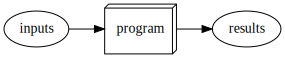

In [ ]:
# hide

# Let's try a bit
gv("program[shape=box3d width=1 height=0.7] inputs->program->results")

In [ ]:
gv("program[shape=box3d width=1 height=0.7] inputs->program->results").__dict__

{'filename': 'Source.gv',
 '_encoding': 'utf-8',
 'source': 'digraph G {  rankdir="LR" program[shape=box3d width=1 height=0.7] inputs->program->results; }'}

In [ ]:
# exportest
@pytest.mark.parametrize("rankdir", [None, "LR", "TD"])
def test_gv(rankdir):
    """Test Graphviz Generation via `gv`"""
    src = "inputs->program->results"
    if rankdir is None:
        graph = gv(src)
        rankdir = "LR"  # default orientation
    else:
        graph = gv(src, rankdir=rankdir)

    assert isinstance(
        graph, graphviz.Source
    ), f"Output shall be a GraphViz Source (but is {type(graph)})"

    gv_src = graph.source
    assert gv_src.startswith("digraph"), f"Source is not a digraph: {gv_src}"
    assert src in gv_src, f"Source input not in Graph Source: {gv_src}"
    assert f'rankdir="{rankdir}"' in gv_src, f"Rankdir {rankdir} not found: {gv_src}"


## Download and unzip utilities

### Download & url_2_text

In [ ]:
# export
def get_url_size(url: str) -> int:
    """Returns the size of URL, or -1 if it cannot get it"""
    with requests.request("HEAD", url) as resp:
        if resp.status_code != 200:
            raise ConnectionError(f"Error when retrieving size from {url}")

        return int(resp.headers.get("Content-Length", -1))


In [ ]:
# export
def download(url: str, dest: PathStr = None) -> Path:
    """Download file and return the Path of the downloaded file

    If the destination is not specified, download in the current directory
    with the name specified in the URL
    """
    # We can allow empty destination, in which case we use file name in URL
    # We need to ensure that destination is a Path
    dest = Path(dest or url.rpartition("/")[-1])

    # For big files, we will split into chunks
    # We might also consider adding a progress bar
    size = get_url_size(url)
    if size < 1024 * 1024:
        with requests.get(url) as resp:
            resp.raise_for_status()
            dest.write_bytes(resp.content)

    else:
        with requests.get(url, stream=True) as resp:
            resp.raise_for_status()
            with dest.open("wb") as f:
                for chunk in resp.iter_content(chunk_size=8192):
                    f.write(chunk)

    logger.info(f"Downloaded {url} to {dest}")
    return dest


def url_2_text(url: str) -> str:
    """Extract text content from an URL (textual content for an HTML)"""
    resp = requests.get(url)
    if resp.status_code != 200:
        raise ConnectionError(f"Error when retrieving text content from {url}")

    resp.encoding = "utf-8"
    content_type = resp.headers["Content-Type"]
    if "html" in content_type:
        text = BeautifulSoup(resp.text).text
    else:
        text = resp.text
    return text


In [ ]:
# exportest
GITHUB_TEST_DATA_URL = "https://raw.githubusercontent.com/unpackAI/unpackai/main/test/test_data/"
url_raw_txt = f"{GITHUB_TEST_DATA_URL}/to_download.txt"
test_data_txt = (DATA_DIR / "to_download.txt").read_text()


@pytest.fixture(scope="session")
def check_connection_github():
    try:
        with requests.request("HEAD", url_raw_txt, timeout=1) as resp:
            resp.raise_for_status()
    except (requests.exceptions.ConnectionError, requests.exceptions.ReadTimeout) as e:
        pytest.xfail(f"Cannot connect to Github: {e}")


In [ ]:
# exportest
def test_get_url_size(check_connection_github):
    assert get_url_size(url_raw_txt) == 264, f"Wrong size for {url_raw_txt}"


def test_download_dest(check_connection_github, tmpdir):
    """Test download of file to a destination"""
    dest = Path(tmpdir / "to_download.txt")
    download(url_raw_txt, dest)
    assert dest.is_file()
    assert dest.read_text() == test_data_txt


def test_download_empty(check_connection_github, tmpdir):
    """Test download of file without destination"""
    dest = Path("to_download.txt")
    download(url_raw_txt)
    try:
        assert dest.is_file()
        assert dest.read_text() == test_data_txt
    finally:
        dest.unlink()


def test_url_2_text(check_connection_github):
    """Test extraction of text from URL"""
    assert url_2_text(url_raw_txt) == test_data_txt


### Unpack & Download-unpack

In [ ]:
# export

# We will re-use directly the unzip function from shutil
# Since we want it in our "all", we just assign to itself so nbdev can detect it
unpack_archive = shutil.unpack_archive

# Equivalent to:
# def unpack_archive(filename, extract_dir=None, format=None):
#     return shutil.unpack_archive(filename, extract_dir=None, format=None)


def download_and_unpack(url: str, extract_dir: PathStr = None, fmt: str = None) -> Path:
    """Download a file and unzip it. Returns the path of unzipped directory

    Args:
        url: URL of the archive to download
        extract_dir: name of the target directory, where the archive is unpacked.
                    If not provided, <working directory> / <archive name without extesion> is used.
        fmt: archive format (one of "zip", "tar", "gztar", "bztar",or "xztar").
                Or any other registered format. If not provided, it is guessed from extension.
    """
    # We will store the downloaded archive in a temporary folder
    with tempfile.TemporaryDirectory() as tmpdirname:
        dest = Path(tmpdirname) / url.split("?")[0].rpartition("/")[-1]
        download(url, dest=dest)

        if extract_dir is None:
            extract_dir = Path.cwd() / dest.stem

        unpack_archive(str(dest), extract_dir=str(extract_dir), format=fmt)
        logger.info(f"Extracted {url} to folder {dest}")

    return Path(extract_dir)


In [ ]:
# exportest
url_ar = (
    r"https://alaska.usgs.gov/data/landBirds/sewardPeninsula/2012/"
    "avianHabitat_sewardPeninsula_McNew_2012.zip"
)


@pytest.mark.parametrize("url", [url_ar, url_ar + "?x=123"], ids=["url", "url?x=y"])
@pytest.mark.parametrize("dest", [None, "unzip_dir"], ids=["no dest", "dest"])
def test_download_and_unpack(url, dest, tmpdir):
    """Test download and unzip with `download_and_unpack`"""
    if dest is None:
        dest = Path(url.split("?")[0].rpartition("/")[-1]).stem

    extract_dir = Path(tmpdir / dest)
    download_and_unpack(url, extract_dir=extract_dir)

    df_files = ls(extract_dir)
    obt_files = {k: v for k, v in zip(df_files.Name, df_files.Size)}

    exp_files = {
        "avianHabitat_sewardPeninsula_McNew_2012.csv": 60617,
        "avianHabitat_sewardPeninsula_McNew_2012.html": 22883,
        "avianHabitat_sewardPeninsula_McNew_2012.xml": 14408,
    }
    assert (
        obt_files == exp_files
    ), f"Differences found in list of files:\n{obt_files}\nvs\n{exp_files}"


### CSV in archive to DataFrame

In [ ]:
# exporti
def _zip_csv_2_df(zip_path:Path, csv_path:PathStr) -> pd.DataFrame:
    """CSV in zip to DataFrame"""
    with ZipFile(zip_path) as zf:
        try:
            with zf.open(str(csv_path)) as f_csv:
                return pd.read_csv(f_csv)
        except KeyError:
            files = "\n".join(f" * {f}" for f in zf.namelist() if f.lower().endswith(".csv"))
            raise FileNotFoundError(
                f'CSV file "{csv_path}" not found in "{zip_path}" '
                f"containing following CSV files:\n{files}"
            ) from None


def _tar_csv_2_df(tar_path:Path, csv_path:PathStr) -> pd.DataFrame:
    """CSV in tar to DataFrame"""
    with tarfile.open(tar_path) as tf:
        try:
            csv_member = tf.getmember(str(csv_path))
            return pd.read_csv(tf.extractfile(member=csv_member))
        except KeyError:
            files = "\n".join(f" * {f}" for f in tf.getnames() if f.lower().endswith(".csv"))
            raise FileNotFoundError(
                f'CSV file "{csv_path}" not found in "{tar_path}" '
                f"containing following CSV files:\n{files}"
            ) from None


In [ ]:
# export
def read_csv_from_zip(archive: PathURL, csv_path: PathStr) -> pd.DataFrame:
    """Load a CSV file inside a zip/tar and returns the equivalent pandas `DataFrame`

    Args:
        archive: path or URL of the zip (or tar/tag.gz) file
        csv_path: path of csv relative to root of archive
            Note: if root is a folder, csv_path shall include this path (e.g. "archive/my_table.csv")
    """
    if Path(csv_path).suffix.lower() != ".csv":
        raise AttributeError(
            f'2nd argument ("csv_path") shall be a CSV file but is "{csv_path}"'
        )

    with tempfile.TemporaryDirectory() as tmpdirname:
        if isinstance(archive, str) and archive.startswith("http"):
            zip_path = Path(tmpdirname) / archive.split("?")[0].rpartition("/")[-1]
            download(archive, dest=zip_path)
        else:
            zip_path = Path(archive)

        extensions = "".join(zip_path.suffixes[-2:]).lower()
        if extensions == ".zip":
            return _zip_csv_2_df(zip_path, csv_path)
        elif extensions in (".tar", ".tar.gz"):
            return _tar_csv_2_df(zip_path, csv_path)
        else:
            raise AttributeError(
                f'Archive shall be either .zip, .tar, or .tar.gz but is "{zip_path}"'
            )

In [ ]:
# hide
read_csv_from_zip(DATA_DIR / "archive.zip", "100_rows.csv")

,id,name,company,some_integer,some_float,zone,type
0,1,"Eldon Base for stackable storage shelf, platinum",Muhammed MacIntyre,3,38.94,Nunavut,Storage & Organization
1,2,"1.7 Cubic Foot Compact ""Cube"" Office Refrigera...",Barry French,293,208.16,Nunavut,Appliances
2,3,"Cardinal Slant-D? Ring Binder, Heavy Gauge Vinyl",Barry French,293,8.69,Nunavut,Binders and Binder Accessories
3,4,R380,Clay Rozendal,483,195.99,Nunavut,Telephones and Communication
4,5,Holmes HEPA Air Purifier,Carlos Soltero,515,21.78,Nunavut,Appliances
...,...,...,...,...,...,...,...
95,96,"Linden? 12"" Wall Clock With Oak Frame",Doug Bickford,10535,33.98,Northwest Territories,Office Furnishings
96,97,Newell 326,Doug Bickford,10535,1.76,Northwest Territories,Pens & Art Supplies
97,98,Prismacolor Color Pencil Set,Jamie Kunitz,10789,19.84,Northwest Territories,Pens & Art Supplies
98,99,Xerox Blank Computer Paper,Anthony Johnson,10791,19.98,Northwest Territories,Paper


In [ ]:
# hide
read_csv_from_zip(DATA_DIR / "archive.tar.gz", "100_rows.csv")

,id,name,company,some_integer,some_float,zone,type
0,1,"Eldon Base for stackable storage shelf, platinum",Muhammed MacIntyre,3,38.94,Nunavut,Storage & Organization
1,2,"1.7 Cubic Foot Compact ""Cube"" Office Refrigera...",Barry French,293,208.16,Nunavut,Appliances
2,3,"Cardinal Slant-D? Ring Binder, Heavy Gauge Vinyl",Barry French,293,8.69,Nunavut,Binders and Binder Accessories
3,4,R380,Clay Rozendal,483,195.99,Nunavut,Telephones and Communication
4,5,Holmes HEPA Air Purifier,Carlos Soltero,515,21.78,Nunavut,Appliances
...,...,...,...,...,...,...,...
95,96,"Linden? 12"" Wall Clock With Oak Frame",Doug Bickford,10535,33.98,Northwest Territories,Office Furnishings
96,97,Newell 326,Doug Bickford,10535,1.76,Northwest Territories,Pens & Art Supplies
97,98,Prismacolor Color Pencil Set,Jamie Kunitz,10789,19.84,Northwest Territories,Pens & Art Supplies
98,99,Xerox Blank Computer Paper,Anthony Johnson,10791,19.98,Northwest Territories,Paper


In [ ]:
# exportest
LOCAL_ZIP_FLAT = DATA_DIR / "archive.zip"
LOCAL_TAR_FLAT = DATA_DIR / "archive.tar"
LOCAL_GZ_FLAT = DATA_DIR / "archive.tar.gz"
LOCAL_ZIP_FOLDER = DATA_DIR / "archived_folder.zip"
GITHUB_ZIP_FLAT = f"{GITHUB_TEST_DATA_URL}/archive.zip"
GITHUB_ZIP_FOLDER = f"{GITHUB_TEST_DATA_URL}/archived_folder.zip"


@pytest.mark.parametrize(
    "archive,csv",
    [
        (LOCAL_ZIP_FLAT, "100_rows.csv"),
        (LOCAL_TAR_FLAT, "100_rows.csv"),
        (LOCAL_GZ_FLAT, "100_rows.csv"),
        (LOCAL_ZIP_FOLDER, "archived_folder/100_rows (folder).csv"),
        (LOCAL_ZIP_FOLDER, "archived_folder/sub_folder/100_rows (subfolder).csv"),
    ],
    ids=["flat (zip)", "flat (tar)", "flat (tar.gz)", "folder", "subfolder"],
)
def test_read_csv_from_zip_local(archive, csv):
    """Test reading CSV from a local zip with read_csv_from_zip"""
    df = read_csv_from_zip(archive, csv)
    assert isinstance(df, pd.DataFrame), f"Result is not a DataFrame: {df}"
    assert len(df) == 100


@pytest.mark.parametrize(
    "archive,csv",
    [
        (GITHUB_ZIP_FLAT, "100_rows.csv"),
        (GITHUB_ZIP_FOLDER, "archived_folder/100_rows (folder).csv"),
        (GITHUB_ZIP_FOLDER, "archived_folder/sub_folder/100_rows (subfolder).csv"),
    ],
    ids=["flat", "folder", "subfolder"],
)
def test_read_csv_from_zip_github(archive, csv, check_connection_github):
    """Test reading CSV from a URL zip in GitHub with read_csv_from_zip"""
    df = read_csv_from_zip(archive, csv)
    assert isinstance(df, pd.DataFrame), f"Result is not a DataFrame: {df}"
    assert len(df) == 100


def test_read_csv_from_zip_url():
    """Test reading CSV from a URL zip with read_csv_from_zip"""
    url_ar = (
        r"https://alaska.usgs.gov/data/landBirds/sewardPeninsula/2012/"
        "avianHabitat_sewardPeninsula_McNew_2012.zip"
    )
    df = read_csv_from_zip(url_ar, "avianHabitat_sewardPeninsula_McNew_2012.csv")
    assert isinstance(df, pd.DataFrame), f"Result is not a DataFrame: {df}"
    assert len(df) == 1070


@pytest.mark.parametrize(
    "archive,csv,error",
    [
        ("does_not_exist.zip", "table.csv", FileNotFoundError),
        (LOCAL_ZIP_FLAT, "does_not_exist.csv", FileNotFoundError),
        (LOCAL_TAR_FLAT, "does_not_exist.csv", FileNotFoundError),
        (LOCAL_GZ_FLAT, "does_not_exist.csv", FileNotFoundError),
        (LOCAL_ZIP_FLAT, "not_a_csv.txt", AttributeError),
        (LOCAL_ZIP_FLAT, "not_a_csv", AttributeError),
        (DATA_DIR / "to_download.txt", "table.csv", AttributeError),
    ],
    ids=[
        "zip missing",
        "csv missing (zip)",
        "csv missing (tar)",
        "csv missing (tar.gz)",
        "not csv (extension)",
        "not csv (no extension)",
        "not archive",
    ],
)
def test_read_csv_from_zip_robustness(archive, csv, error):
    """Test robustness of read_csv_from_zip"""
    with pytest.raises(error):
        read_csv_from_zip(archive, csv)


<!-- Hide -->
# Running all Test Cases

In [ ]:
# export
try:
    ishell = get_ipython()
except NameError as e:
    from IPython.testing.globalipapp import get_ipython, start_ipython
    ishell = start_ipython()
    print(get_ipython())

In [ ]:
# hide
ipytest.run()

....................

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "HEAD /unpackAI/unpackai/main/test/test_data//to_download.txt HTTP/1.1" 301 0
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "HEAD /unpackAI/unpackai/main/test/test_data/to_download.txt HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "HEAD /unpackAI/unpackai/main/test/test_data//to_download.txt HTTP/1.1" 301 0
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "HEAD /unpackAI/unpackai/main/test/test_data/to_download.txt HTTP/1.1" 200 0


.

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "HEAD /unpackAI/unpackai/main/test/test_data//to_download.txt HTTP/1.1" 301 0
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "HEAD /unpackAI/unpackai/main/test/test_data/to_download.txt HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /unpackAI/unpackai/main/test/test_data//to_download.txt HTTP/1.1" 301 89
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /unpackAI/unpackai/main/test/test_data/to_download.txt HTTP/1.1" 200 264
INFO:unpackai.utils:Downloaded https://raw.githubusercontent.com/unpackAI/unpackai/main/test/test_data//to_download.txt to C:\Users\jthuong\AppData\Local\Temp\pytest-of-jthuong\pytest-50\test_download_dest0\to_download.txt


.

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "HEAD /unpackAI/unpackai/main/test/test_data//to_download.txt HTTP/1.1" 301 0
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "HEAD /unpackAI/unpackai/main/test/test_data/to_download.txt HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443


F

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /unpackAI/unpackai/main/test/test_data//to_download.txt HTTP/1.1" 301 89
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /unpackAI/unpackai/main/test/test_data/to_download.txt HTTP/1.1" 200 264


.

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): alaska.usgs.gov:443
DEBUG:urllib3.connectionpool:https://alaska.usgs.gov:443 "HEAD /data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): alaska.usgs.gov:443
DEBUG:urllib3.connectionpool:https://alaska.usgs.gov:443 "GET /data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip HTTP/1.1" 200 98526
INFO:unpackai.utils:Downloaded https://alaska.usgs.gov/data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip to C:\Users\jthuong\AppData\Local\Temp\tmpnt5wxuk9\avianHabitat_sewardPeninsula_McNew_2012.zip
INFO:unpackai.utils:Extracted https://alaska.usgs.gov/data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip to folder C:\Users\jthuong\AppData\Local\Temp\tmpnt5wxuk9\avianHabitat_sewardPeninsula_McNew_2012.zip


.

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): alaska.usgs.gov:443
DEBUG:urllib3.connectionpool:https://alaska.usgs.gov:443 "HEAD /data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip?x=123 HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): alaska.usgs.gov:443
DEBUG:urllib3.connectionpool:https://alaska.usgs.gov:443 "GET /data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip?x=123 HTTP/1.1" 200 98526
INFO:unpackai.utils:Downloaded https://alaska.usgs.gov/data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip?x=123 to C:\Users\jthuong\AppData\Local\Temp\tmp7uojme8t\avianHabitat_sewardPeninsula_McNew_2012.zip
INFO:unpackai.utils:Extracted https://alaska.usgs.gov/data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip?x=123 to folder C:\Users\jthuong\AppData\Local\Temp\tmp7uojme8t\avianHabitat_sewardPeninsula_McNew_2012.zip


.

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): alaska.usgs.gov:443
DEBUG:urllib3.connectionpool:https://alaska.usgs.gov:443 "HEAD /data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): alaska.usgs.gov:443
DEBUG:urllib3.connectionpool:https://alaska.usgs.gov:443 "GET /data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip HTTP/1.1" 200 98526
INFO:unpackai.utils:Downloaded https://alaska.usgs.gov/data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip to C:\Users\jthuong\AppData\Local\Temp\tmpds2ss3wl\avianHabitat_sewardPeninsula_McNew_2012.zip
INFO:unpackai.utils:Extracted https://alaska.usgs.gov/data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip to folder C:\Users\jthuong\AppData\Local\Temp\tmpds2ss3wl\avianHabitat_sewardPeninsula_McNew_2012.zip


.

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): alaska.usgs.gov:443
DEBUG:urllib3.connectionpool:https://alaska.usgs.gov:443 "HEAD /data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip?x=123 HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): alaska.usgs.gov:443
DEBUG:urllib3.connectionpool:https://alaska.usgs.gov:443 "GET /data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip?x=123 HTTP/1.1" 200 98526
INFO:unpackai.utils:Downloaded https://alaska.usgs.gov/data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip?x=123 to C:\Users\jthuong\AppData\Local\Temp\tmpomzw0927\avianHabitat_sewardPeninsula_McNew_2012.zip
INFO:unpackai.utils:Extracted https://alaska.usgs.gov/data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip?x=123 to folder C:\Users\jthuong\AppData\Local\Temp\tmpomzw0927\avianHabitat_sewardPeninsula_McNew_2012.zip


......

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "HEAD /unpackAI/unpackai/main/test/test_data//archive.zip HTTP/1.1" 301 0
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "HEAD /unpackAI/unpackai/main/test/test_data/archive.zip HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /unpackAI/unpackai/main/test/test_data//archive.zip HTTP/1.1" 301 85
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /unpackAI/unpackai/main/test/test_data/archive.zip HTTP/1.1" 200 4091
INFO:unpackai.utils:Downloaded https://raw.githubusercontent.com/unpackAI/unpackai/main/test/test_data//archive.zip to C:\Users\jthuong\AppData\Local\Temp\tmp38xxhbhr\archive.zip


.

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "HEAD /unpackAI/unpackai/main/test/test_data//archived_folder.zip HTTP/1.1" 301 0


F

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com:443


F

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): alaska.usgs.gov:443
DEBUG:urllib3.connectionpool:https://alaska.usgs.gov:443 "HEAD /data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): alaska.usgs.gov:443
DEBUG:urllib3.connectionpool:https://alaska.usgs.gov:443 "GET /data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip HTTP/1.1" 200 98526
INFO:unpackai.utils:Downloaded https://alaska.usgs.gov/data/landBirds/sewardPeninsula/2012/avianHabitat_sewardPeninsula_McNew_2012.zip to C:\Users\jthuong\AppData\Local\Temp\tmp2al_urpd\avianHabitat_sewardPeninsula_McNew_2012.zip


........

DEBUG:PIL.Image:Importing BlpImagePlugin
DEBUG:PIL.Image:Importing BmpImagePlugin
DEBUG:PIL.Image:Importing BufrStubImagePlugin
DEBUG:PIL.Image:Importing CurImagePlugin
DEBUG:PIL.Image:Importing DcxImagePlugin
DEBUG:PIL.Image:Importing DdsImagePlugin
DEBUG:PIL.Image:Importing EpsImagePlugin
DEBUG:PIL.Image:Importing FitsStubImagePlugin
DEBUG:PIL.Image:Importing FliImagePlugin
DEBUG:PIL.Image:Importing FpxImagePlugin
DEBUG:PIL.Image:Image: failed to import FpxImagePlugin: No module named 'olefile'
DEBUG:PIL.Image:Importing FtexImagePlugin
DEBUG:PIL.Image:Importing GbrImagePlugin
DEBUG:PIL.Image:Importing GifImagePlugin
DEBUG:PIL.Image:Importing GribStubImagePlugin
DEBUG:PIL.Image:Importing Hdf5StubImagePlugin
DEBUG:PIL.Image:Importing IcnsImagePlugin
DEBUG:PIL.Image:Importing IcoImagePlugin
DEBUG:PIL.Image:Importing ImImagePlugin
DEBUG:PIL.Image:Importing ImtImagePlugin
DEBUG:PIL.Image:Importing IptcImagePlugin
DEBUG:PIL.Image:Importing JpegImagePlugin
DEBUG:PIL.Image:Importing Jpeg2KIm

F

.

.

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 105514


F

..

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 64


F

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 69


F...s.s

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 69
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 105514


.                                  [100%]##vso[results.publish type=JUnit;runTitle='Pytest results';]e:\AnsysDev\_perso_repo\unpackai\nbs\test-output.xml
##vso[task.logissue type=error;]7 test(s) failed, 59 test(s) collected.
##vso[task.logissue type=warning;]Coverage XML was not created, skipping upload.

============================================ FAILURES =============================================
_______________________________________ test_download_empty _______________________________________

self = <urllib3.connectionpool.HTTPSConnectionPool object at 0x000001B64E182F40>, method = 'GET'
url = '/unpackAI/unpackai/main/test/test_data//to_download.txt', body = None
headers = {'User-Agent': 'python-requests/2.26.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'}
retries = Retry(total=0, connect=None, read=False, redirect=None, status=None), redirect = False
assert_same_host = False, timeout = Timeout(connect=None, read=None, total=None)
pool_ti